<a href="https://colab.research.google.com/github/agungtriu/Belajar-Pengembangan-Machine-Learning/blob/master/Submission_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!wget --no-check-certificate \
  https://raw.githubusercontent.com/agungtriu/Belajar-Pengembangan-Machine-Learning/master/Submission/Submission%202%20Time%20Series/HR2019-04-10.csv \
  -O /content/HR2019-04-10.csv

--2020-08-19 12:40:56--  https://raw.githubusercontent.com/agungtriu/Belajar-Pengembangan-Machine-Learning/master/Submission/Submission%202%20Time%20Series/HR2019-04-10.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175489 (171K) [text/plain]
Saving to: ‘/content/HR2019-04-10.csv’

/content/HR2019-04- 100%[===================>] 171.38K  --.-KB/s    in 0.02s   

2020-08-19 12:40:57 (7.62 MB/s) - ‘/content/HR2019-04-10.csv’ saved [175489/175489]



In [13]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

data_train = pd.read_csv('HR2019-04-10.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    10900 non-null  object
 1   value   10900 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 170.4+ KB


In [14]:
data_train['value']= data_train['value'].astype(np.float32)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    10900 non-null  object 
 1   value   10900 non-null  float32
dtypes: float32(1), object(1)
memory usage: 127.9+ KB


In [15]:
data_train

,time,value
0,00:00:01,61.0
1,00:00:06,63.0
2,00:00:16,62.0
3,00:00:26,63.0
4,00:00:41,63.0
...,...,...
10895,23:58:25,83.0
10896,23:58:30,83.0
10897,23:58:35,81.0
10898,23:58:40,78.0


In [16]:
data_train.isnull().sum()

time     0
value    0
dtype: int64

In [17]:
times = data_train['time'].values
value  = data_train['value'].values

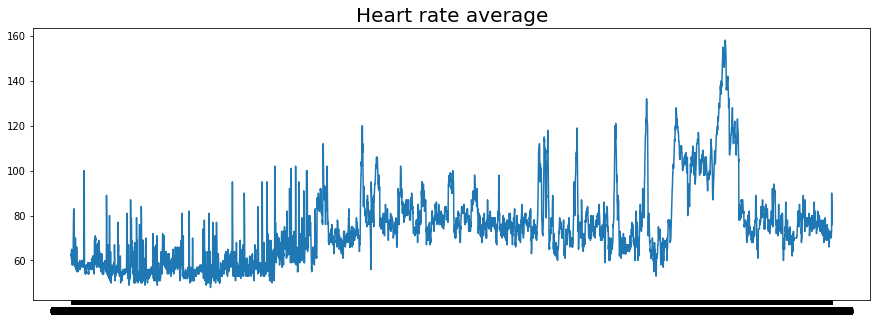

In [18]:
plt.figure(figsize=(15,5))
plt.plot(times, value)
plt.title('Heart rate average',
          fontsize=20);

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
train_set = windowed_dataset(value, window_size=60, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<10):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [23]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=[callbacks])

Epoch 1/500
55/55 [==============================] - 2s 29ms/step - loss: 74.1523 - mae: 74.6523
Epoch 2/500
55/55 [==============================] - 2s 29ms/step - loss: 74.1001 - mae: 74.6001
Epoch 3/500
55/55 [==============================] - 2s 31ms/step - loss: 74.0551 - mae: 74.5551
Epoch 4/500
55/55 [==============================] - 2s 32ms/step - loss: 74.0209 - mae: 74.5209
Epoch 5/500
55/55 [==============================] - 2s 29ms/step - loss: 73.9844 - mae: 74.4844
Epoch 6/500
55/55 [==============================] - 2s 29ms/step - loss: 73.9423 - mae: 74.4423
Epoch 7/500
55/55 [==============================] - 2s 30ms/step - loss: 73.9027 - mae: 74.4027
Epoch 8/500
55/55 [==============================] - 2s 31ms/step - loss: 73.8668 - mae: 74.3668
Epoch 9/500
55/55 [==============================] - 2s 29ms/step - loss: 73.8279 - mae: 74.3279
Epoch 10/500
55/55 [==============================] - 2s 29ms/step - loss: 73.7951 - mae: 74.2951
Epoch 11/500
55/55 [=========

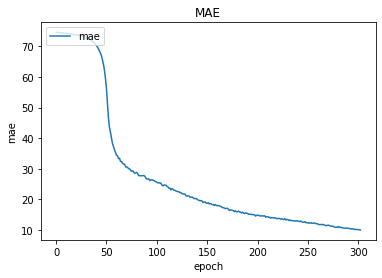

In [24]:
plt.plot(history.history['mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['mae'], loc='upper left')
plt.show()